In [1]:
# | code-summary: code -- load dependencies and data and specify analysis parameters

from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import simulate_data
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

section_introduction = """
As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-{section_tag}Summary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the full dataset to similar extents. To build on this finding of broad model equivalence with respect to the results reported by @murdock1970interresponse, we consider the model variants under broader experimental conditions.
"""

figure_caption = """Comparison of summary statistics between each model against observed data [@murdock1970interresponse]"""

section_tag = "Murd1962"

data_path = "../data/Murdock1962.csv"

data_query = "subject < 4"

model_paths = ["compmemlearn.models.Instance_CMR", "compmemlearn.models.Instance_CMR"]

model_names = ["Trace Scaling", "Echo Scaling"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity',
        "delay_drift_rate",
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        'choice_sensitivity',
        #    "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
    ]
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {"choice_sensitivity": 1, "feature_sensitivity": 1},
    {"context_sensitivity": 1, "feature_sensitivity": 1},
]


In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

# load dataset and extract key metadata
events = pd.read_csv(data_path).query(data_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)
    
    for boundary_index in range(2):
        x = [each[boundary_index] for each in bounds[model_index]]

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

In [3]:
#| echo: false
#| input: false
#| output: asis

print(section_introduction.format(section_tag=section_tag))


As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-Murd1962Summary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these ben

In [4]:
events

,Unnamed: 0,subject,list,item,input,output,study,recall,repeat,intrusion,list length
0,0,1,1,1,1,5.0,True,True,0,False,20
1,1,1,1,2,2,7.0,True,True,0,False,20
2,2,1,1,3,3,NaN,True,False,0,False,20
3,3,1,1,4,4,NaN,True,False,0,False,20
4,4,1,1,5,5,NaN,True,False,0,False,20
...,...,...,...,...,...,...,...,...,...,...,...
69595,9595,3,80,36,36,NaN,True,False,0,False,40
69596,9596,3,80,37,37,8.0,True,True,0,False,40
69597,9597,3,80,38,38,1.0,True,True,0,False,40
69598,9598,3,80,39,39,2.0,True,True,0,False,40


In [6]:
#| code-summary: code -- 1) fit models to entire dataset rather than participant-by-participant
#| output: false

fit_result = []
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
            events,
            init_model,
            fixed_parameters[model_index],
            free_parameters[model_index],
        )

    fit_result.append(
        differential_evolution(
            cost_function, bounds[model_index], disp=True
        ))
    print(fit_result[-1])

differential_evolution step 1: f(x)= 20688.9
differential_evolution step 2: f(x)= 20688.9
differential_evolution step 3: f(x)= 20196
differential_evolution step 4: f(x)= 20025.2
differential_evolution step 5: f(x)= 20025.2
differential_evolution step 6: f(x)= 20025.2
differential_evolution step 7: f(x)= 20025.2
differential_evolution step 8: f(x)= 19900.6
differential_evolution step 9: f(x)= 19900.6
differential_evolution step 10: f(x)= 19871.1
differential_evolution step 11: f(x)= 19871.1
differential_evolution step 12: f(x)= 19778.2
differential_evolution step 13: f(x)= 19778.2
differential_evolution step 14: f(x)= 17819.3
differential_evolution step 15: f(x)= 17819.3
differential_evolution step 16: f(x)= 17819.3
differential_evolution step 17: f(x)= 17819.3
differential_evolution step 18: f(x)= 17819.3
differential_evolution step 19: f(x)= 17819.3
differential_evolution step 20: f(x)= 17819.3
differential_evolution step 21: f(x)= 17819.3
differential_evolution step 22: f(x)= 17819.3

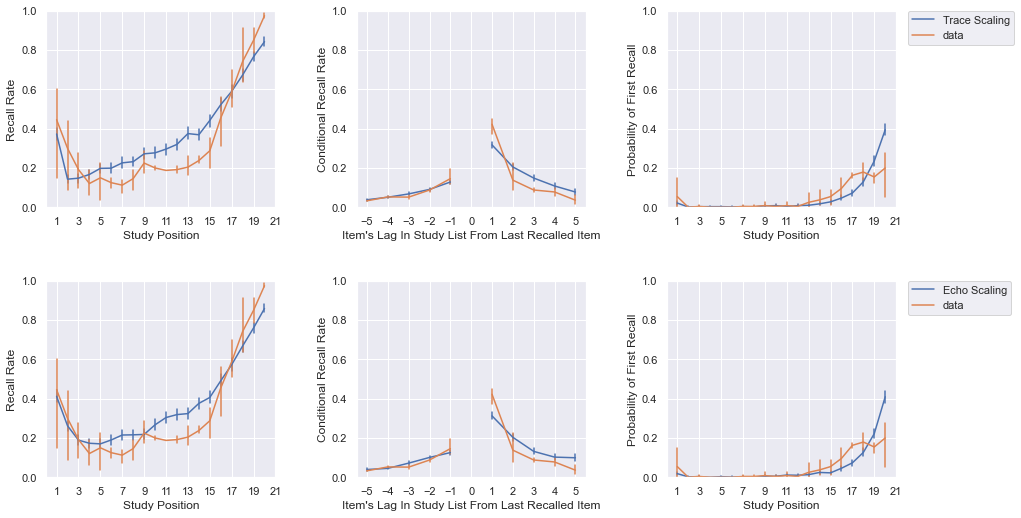

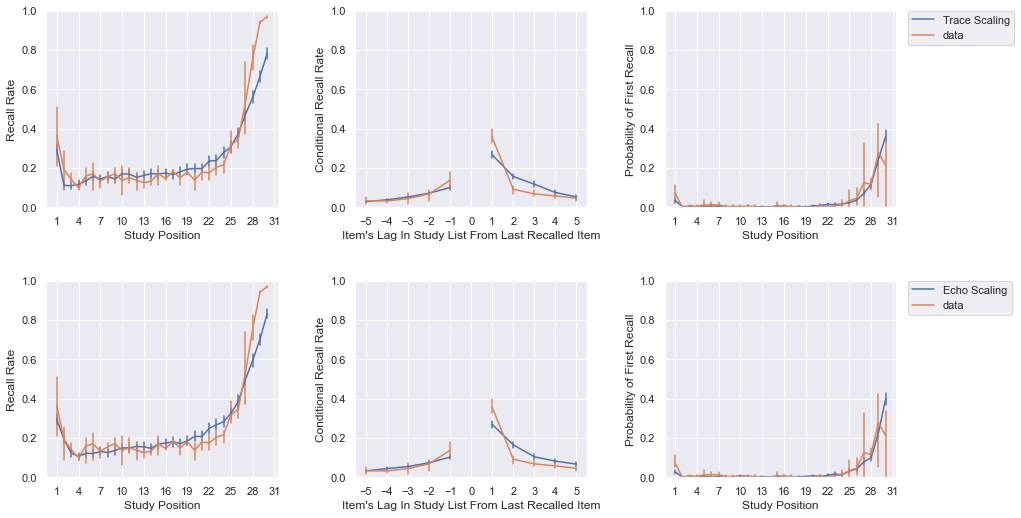

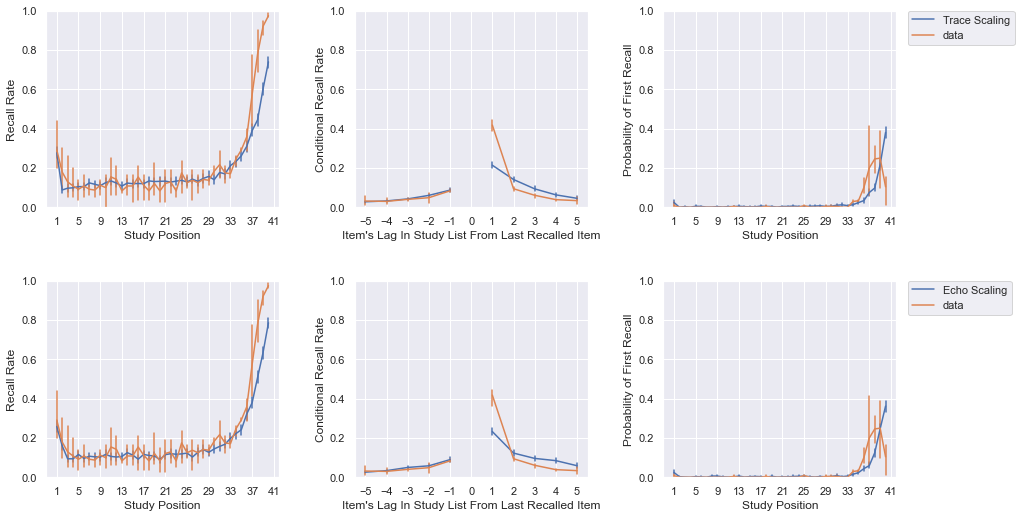

In [11]:
# | output: false
# | code-summary: code -- 2) compose simulated spc, lag-crp, pfr from overall fitting results

sns.set(style='darkgrid')

if 'list length' in events.columns:
    list_lengths = List(pd.unique(events["list length"]).tolist())
else:
    list_lengths = List([np.max(events.input)])

for list_length in list_lengths:

    fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False) 
    for model_index, model_class in enumerate(models):

        fitted_parameters = Dict.empty(
            key_type=types.unicode_type, value_type=types.float64
        )
        for i in range(len(fit_result[model_index].x)):
            fitted_parameters[free_parameters[model_index][i]] = fit_result[model_index].x[i]
        for key in fixed_parameters[model_index]:
            fitted_parameters[key] = fixed_parameters[model_index][key]

        model = model_class(list_length, list_length, fitted_parameters)

        sim_df = simulate_data(model, 1000)

        if len(list_lengths) > 1:
            true_df = events.query(f'`list length` == {list_length}')
        else:
            true_df = events.copy()

        sim_spc = apply_and_concatenate(
                fr.spc,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )

        sim_lag_crp = apply_and_concatenate(
                fr.lag_crp,
                sim_df,
                true_df,
                "source",
                labels=[model_names[model_index], "data"],
            )

        sim_pfr = apply_and_concatenate(
                fr.pnr,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )
        sim_pfr = sim_pfr.query("output <= 1")

        # serial position curve
        sns.lineplot(ax=axes[model_index, 0], data=sim_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
        axes[model_index, 0].set(xlabel='Study Position', ylabel='Recall Rate')
        axes[model_index, 0].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 0].set_ylim((0, 1))

        # lag crp curve
        max_lag = 5
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_neg), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_pos), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        axes[model_index, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
        axes[model_index, 1].set_xticks(np.arange(-5, 6, 1))
        axes[model_index, 1].set_ylim((0, 1))


        # pfr
        sns.lineplot(data=sim_pfr, x='input', y='prob', err_style='bars', ax=axes[model_index, 2], hue='source')
        axes[model_index, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
        axes[model_index, 2].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 2].set_ylim((0, 1))

        # set legend of axis 2 outside the plot, to the right
        axes[model_index, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout(pad=3)
    plt.savefig(f'overall_{section_tag}_length_{list_length}.pdf', bbox_inches='tight')